<a href="https://colab.research.google.com/github/vlad-danaila/ml-cancer-detection/blob/master/Cancer_Detection_Ensable_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install sklearn matplotlib GPUtil

In [ ]:
!pip3 install "pillow<7"

In [ ]:
!pip3 install torch==1.3.1+cu92 torchvision==0.4.2+cu92 -f https://download.pytorch.org/whl/torch_stable.html

**Download Data**

Mount my google drive, where the dataset is stored.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as e:
    print(e)

Unzip the dataset into the folder "dataset".

In [ ]:
!rm -vrf "dataset"
!mkdir "dataset"
!cp -r "/content/drive/My Drive/Studiu doctorat leziuni cervicale/cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
# !cp -r "cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
!unzip "dataset/cervigram-image-dataset-v2.zip" -d "dataset"

**Constants**

In [1]:
# TRAIN_PATH = '/content/dataset/data/train/'
# TEST_PATH = '/content/dataset/data/test/'
TRAIN_PATH = 'dataset/data/train/'
TEST_PATH = 'dataset/data/test/'

CROP_SIZE = 260
IMAGE_SIZE = 224
BATCH_SIZE = 50

# prefix = '/content/drive/My Drive/Studiu doctorat leziuni cervicale/V2/Chekpoints & Notebooks/'
prefix = 'Mobilenetv2 Tuning/'
CHACKPOINT_CROSS_ENTROPY_MODEL = prefix + 'checkpint resnext 101.tar'

**Imports**

In [2]:
import torch as t
import torchvision as tv
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import Linear, BCEWithLogitsLoss
import sklearn as sk
import sklearn.metrics
from os import listdir
import time
import random
import statistics
import math

**Deterministic Measurements**

This statements help making the experiments reproductible by fixing the random seeds.

In [3]:
SEED = 0
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.cuda.manual_seed_all(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

**Memory Stats**

In [4]:
import GPUtil
def memory_stats():
  for gpu in GPUtil.getGPUs():
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
memory_stats()

GPU RAM Free: 11019MB | Used: 0MB | Util   0% | Total 11019MB
GPU RAM Free: 11019MB | Used: 0MB | Util   0% | Total 11019MB


**Loading Data**

The dataset is structured in multiple small folders, ecah containing 7 images. The generator iterates through the folders and returns the category and 7 paths: one for each image in the folder.

In [5]:
def sortByLastDigits(elem):
  chars = [c for c in elem if c.isdigit()]
  return 0 if len(chars) == 0 else int(''.join(chars))

def getImagesPaths(root_path):
  for  class_folder in [root_path + f for f in listdir(root_path)]:
      category = int(class_folder[-1])
      for case_folder in listdir(class_folder):
        case_folder_path = class_folder + '/' + case_folder + '/'
        img_files = [case_folder_path + file_name for file_name in listdir(case_folder_path)]
        yield category, sorted(img_files, key = sortByLastDigits)

We define 3 datasets, which loads 3 kinds of images: natural images, images taken through a green lens and images where the doctor aplied iodine solution (which gives a dark red colour). Each dataset has dynamic and static transformations which could be applied to the data. The static transformations are applied on the initialization of the dataset, while the dynamic ones are applied when loading each batch of data.

In [6]:
class SimpleImagesDataset(t.utils.data.Dataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
      for i in range(5):
        img = pil.Image.open(img_files[i])
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.transforms_x != None:
      x = self.transforms_x(x)
    if self.transforms_y != None:
      y = self.transforms_y(y)
    return x, y

  def __len__(self):
    return len(self.dataset)

class GreenLensImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-2]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

class RedImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-1]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

**Preprocess Data**

Convert pytorch tensor to numpy array.

In [7]:
def to_numpy(x):
  return x.cpu().detach().numpy()

Data transformations for the test and training sets.

In [8]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

transforms_train = tv.transforms.Compose([
    tv.transforms.RandomAffine(degrees  = 45, translate = None, scale = (1., 2.), shear = 30),
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda t: t.cuda()),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

transforms_test = tv.transforms.Compose([
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

y_transform = tv.transforms.Lambda(lambda y: t.tensor(y, dtype=t.long, device = 'cuda:0'))

Initialize pytorch datasets and loaders for training and test.

In [9]:
def create_loaders(dataset_class):
  dataset_train = dataset_class(TRAIN_PATH, transforms_x_dynamic = transforms_train, transforms_y_dynamic = y_transform)
  dataset_test = dataset_class(TEST_PATH, transforms_x_static = transforms_test, 
                                                transforms_x_dynamic = tv.transforms.Lambda(lambda t: t.cuda()), transforms_y_dynamic = y_transform)

  loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True, num_workers = 0)
  loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = False, num_workers = 0)
  return loader_train, loader_test, len(dataset_train), len(dataset_test)

In [10]:
loader_train_simple_img, loader_test_simple_img, len_train, len_test = create_loaders(SimpleImagesDataset)

**Visualize Data**

Load a few images so that we can see the efects of the data augmentation on the training set.

In [11]:
def plot_one_prediction(x, label, pred):  
  x, label, pred = to_numpy(x), to_numpy(label), to_numpy(pred)
  x = np.transpose(x, [1, 2, 0])
  if x.shape[-1] == 1:
    x = x.squeeze()
  x = x * np.array(norm_std) + np.array(norm_mean)
  plt.title(label, color = 'green' if label == pred else 'red')
  plt.imshow(x)

def plot_predictions(imgs, labels, preds):  
  fig = plt.figure(figsize = (20, 5))
  for i in range(20):
    fig.add_subplot(2, 10, i + 1, xticks = [], yticks = [])
    plot_one_prediction(imgs[i], labels[i], preds[i])

In [12]:
# x, y = next(iter(loader_train_simple_img))
# for i in range(7):
#   plot_predictions(x[i], y, y)

**Model**

In [13]:
def get_res_next_101():
  model = t.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
  model.fc.out_features = 4
  model = model.cuda()
  return model

In [14]:
model_simple = t.nn.DataParallel(get_res_next_101())

Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master


**Train & Evaluate**

Timer utility function. This is used to measure the execution speend.

In [15]:
time_start = 0

def timer_start():
  global time_start
  time_start = time.time()

def timer_end():
  return time.time() - time_start

This function trains the network and e valuates it at the same time. It outputs the metrics recorder during the training for both train and test. We are measuring accuracy and the loss. The function also saves a checkpoint of the model every time the accuracy is imporved. In the end we will have a checkpoint of the model which gave the best accuracy.

In [16]:
def train_eval(optimizer, model, loader_train, loader_test, chekpoint_name, epochs):
  metrics = {
      'losses_train': [],
      'losses_test': [],

      'acc_train': [],
      'acc_test': [],

      'prec_train': [],
      'prec_test': [],

      'rec_train': [],
      'rec_test': [],

      'f_score_train': [],
      'f_score_test': [],

      'mean_class_acc_train': [],
      'mean_class_acc_test': []  
  }

  best_mean_acc = 0
  
  loss_weights = t.tensor([1/4] * 4, device='cuda:0')
    
  try:  
    for epoch in range(epochs):
      timer_start()
      loss_fn = t.nn.CrossEntropyLoss(weight = loss_weights)
      # loss_fn = t.nn.CrossEntropyLoss()
      # loss_fn = FocalLoss(gamma = 2)
      train_epoch_loss, train_epoch_acc, train_epoch_precision, train_epoch_recall, train_epoch_f_score = 0, 0, 0, 0, 0
      test_epoch_loss, test_epoch_acc, test_epoch_precision, test_epoch_recall, test_epoch_f_score = 0, 0, 0, 0, 0

      # Train
      model.train()
      conf_matrix = np.zeros((4, 4))
      for x, y in loader_train:
        y_pred = model.forward(x)
        y_pred = y_pred.narrow(1, 0, 4)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
#         memory_stats()
        optimizer.zero_grad()
        y_pred, y = to_numpy(y_pred), to_numpy(y)
        pred = y_pred.argmax(axis = 1)
        ratio = len(y) / len_train
        train_epoch_loss += (loss.item() * ratio)
        train_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio)
        precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
        train_epoch_precision += (precision * ratio)
        train_epoch_recall += (recall * ratio)
        train_epoch_f_score += (f_score * ratio)
        conf_matrix += sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
      class_acc = [conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
      mean_class_acc = statistics.harmonic_mean(class_acc)
      errors = [1 - conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
      errors_strong = [math.exp(100 * e) for e in errors]
      loss_weights = t.tensor([e / sum(errors_strong) for e in errors_strong], device = 'cuda:0')
      metrics['losses_train'].append(train_epoch_loss)
      metrics['acc_train'].append(train_epoch_acc)
      metrics['prec_train'].append(train_epoch_precision)
      metrics['rec_train'].append(train_epoch_recall)
      metrics['f_score_train'].append(train_epoch_f_score)
      metrics['mean_class_acc_train'].append(mean_class_acc) 

      # Evaluate
      model.eval()
      with t.no_grad():
        conf_matrix_test = np.zeros((4, 4))
        for x, y in loader_test:
          y_pred = model.forward(x)
          y_pred = y_pred.narrow(1, 0, 4)
          loss = loss_fn(y_pred, y)
          y_pred, y = to_numpy(y_pred), to_numpy(y)
          pred = y_pred.argmax(axis = 1)
          ratio = len(y) / len_test
          test_epoch_loss += (loss * ratio)
          test_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio )
          precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
          test_epoch_precision += (precision * ratio)
          test_epoch_recall += (recall * ratio)
          test_epoch_f_score += (f_score * ratio)
          conf_matrix_test += sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
        class_acc_test = [conf_matrix_test[i][i] / sum(conf_matrix_test[i]) for i in range(len(conf_matrix_test))]
        mean_class_acc_test = statistics.harmonic_mean(class_acc_test)
        metrics['losses_test'].append(test_epoch_loss)
        metrics['acc_test'].append(test_epoch_acc)
        metrics['prec_test'].append(test_epoch_precision)
        metrics['rec_test'].append(test_epoch_recall)
        metrics['f_score_test'].append(test_epoch_f_score)
        metrics['mean_class_acc_test'].append(mean_class_acc_test) 
      
      if metrics['mean_class_acc_test'][-1] > best_mean_acc:
        best_mean_acc = metrics['mean_class_acc_test'][-1]
        t.save({'model': model.state_dict()}, 'checkpint {}.tar'.format(chekpoint_name))
      print('Epoch {} mean class acc {} acc {} prec {} rec {} f {} minutes {}'.format(
        epoch + 1, metrics['mean_class_acc_test'][-1], metrics['acc_test'][-1], metrics['prec_test'][-1], metrics['rec_test'][-1], metrics['f_score_test'][-1], timer_end() / 60))
  except KeyboardInterrupt as e:
    print(e)  
  print('Ended training')
  return metrics

Plot a metric for both train and test.

In [17]:
def plot_train_test(train, test, title, y_title):
    plt.plot(range(len(train)), train, label = 'train')
    plt.plot(range(len(test)), test, label = 'test')
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.title(title)
    plt.legend()
    plt.show()

In [18]:
def plot_precision_recall(metrics):
    plt.scatter(metrics['prec_train'], metrics['rec_train'], label = 'train')
    plt.scatter(metrics['prec_test'], metrics['rec_test'], label = 'test')
    plt.legend()
    plt.title('Precision-Recall')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

Train a model for several epochs. The steps_learning parameter is a list of tuples. Each tuple specifies the steps and the learning rate.

In [19]:
def do_train(model, loader_train, loader_test, checkpoint_name, steps_learning):
  t.cuda.empty_cache()
  for steps, learn_rate in steps_learning:
    metrics = train_eval(t.optim.Adam(model.parameters(), lr = learn_rate, weight_decay = 0), model, loader_train, loader_test, checkpoint_name, steps)
    
    index_max = np.array(metrics['mean_class_acc_test']).argmax()
    print('Best mean class accuracy :', metrics['mean_class_acc_test'][index_max])
    print('Best test accuracy :', metrics['acc_test'][index_max])
    print('Corresponding precision :', metrics['prec_test'][index_max])
    print('Corresponding recall :', metrics['rec_test'][index_max])
    print('Corresponding f1 score :', metrics['f_score_test'][index_max])

    plot_train_test(metrics['mean_class_acc_train'], metrics['mean_class_acc_test'], 'Mean Class Accuracy (lr = {})'.format(learn_rate), 'Mean Class Accuracy')
    plot_train_test(metrics['losses_train'], metrics['losses_test'], 'Loss (lr = {})'.format(learn_rate), 'Loss')
    plot_train_test(metrics['acc_train'], metrics['acc_test'], 'Accuracy (lr = {})'.format(learn_rate), 'Accuracy')
    plot_train_test(metrics['prec_train'], metrics['prec_test'], 'Precision (lr = {})'.format(learn_rate), 'Precision')
    plot_train_test(metrics['rec_train'], metrics['rec_test'], 'Recall (lr = {})'.format(learn_rate), 'Recall')
    plot_train_test(metrics['f_score_train'], metrics['f_score_test'], 'F1 Score (lr = {})'.format(learn_rate), 'F1 Score')
    plot_precision_recall(metrics)

Perform actual training

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.6/statistics.py:356: RuntimeWarning: divide by zero encountered in double_scalars
  T, total, count = _sum(1/x for x in _fail_neg(data, errmsg))


Epoch 1 mean class acc 0.0 acc 0.3958333333333333 prec 0.26681998556998554 rec 0.21620370370370373 f 0.21445924001323502 minutes 0.7411584774653117
Epoch 2 mean class acc 0.0 acc 0.5416666666666666 prec 0.379458648989899 rec 0.3670138888888889 f 0.34300213565234705 minutes 0.600404159228007
Epoch 3 mean class acc 0.0 acc 0.30833333333333335 prec 0.2592592592592593 rec 0.2451388888888889 f 0.21125286579873903 minutes 0.5864294608434041
Epoch 4 mean class acc 0.0 acc 0.25 prec 0.125 rec 0.20833333333333334 f 0.15211640211640215 minutes 0.586010750134786
Epoch 5 mean class acc 0.0 acc 0.525 prec 0.4077932098765432 rec 0.4350694444444444 f 0.3789778391227666 minutes 0.5899236877759297
Epoch 6 mean class acc 0.0 acc 0.25 prec 0.125 rec 0.20833333333333334 f 0.15624999999999997 minutes 0.5904175599416097
Epoch 7 mean class acc 0.0 acc 0.26666666666666666 prec 0.13762626262626262 rec 0.21759259259259262 f 0.16280016280016282 minutes 0.5890061616897583
Epoch 8 mean class acc 0.0 acc 0.57083333

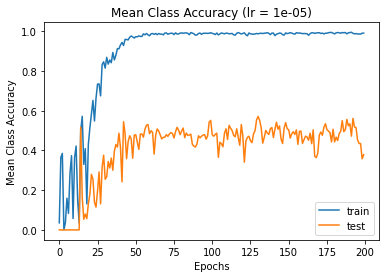

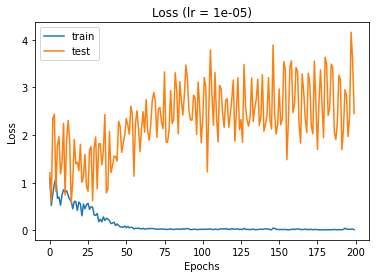

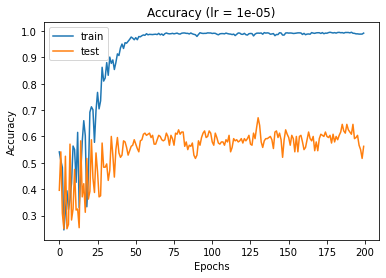

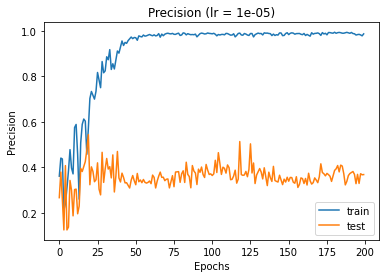

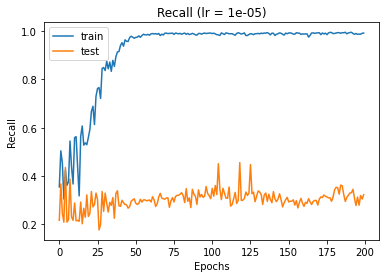

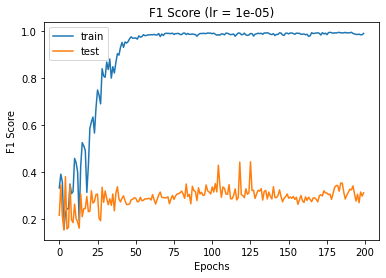

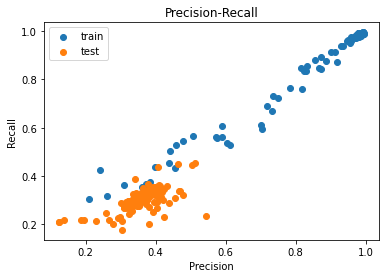

In [20]:
do_train(model_simple, loader_train_simple_img, loader_test_simple_img, 'wce resnext 101', [(200, 1e-5)])

In [21]:
checkpoint = t.load('checkpint wce resnext 101.tar')
model_simple.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [22]:
def calculate_class_acc_for_test_set(model):
  model.eval()
  with t.no_grad():
    conf_matrix = np.zeros((4, 4))
    for x, y in loader_test_simple_img:
      y_pred = model.forward(x)
      y_pred = y_pred.narrow(1, 0, 4)
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      pred = y_pred.argmax(axis = 1)
      cm = sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
      conf_matrix += cm
    print('Confusion matrix:\n', conf_matrix)
    class_acc = [conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
    print('Class acc:\n', class_acc)
    return class_acc

def plot_class_acc(class_acc):
  plt.bar(list(range(4)), class_acc, align='center', alpha=0.5)
  plt.xticks(list(range(4)), list(range(4)))
  plt.xlabel('Classes')
  plt.ylabel('True Positive Rate')
  plt.savefig('AccPerClass.pdf', dpi = 300, format = 'pdf')
  plt.show()

def plot_class_acc_comparison(class_acc_1, class_acc_2, title_1, title_2):
  width = .3
  plt.bar(list(range(4)), class_acc_1, width, alpha=0.5, color = 'green', label = title_1)
  plt.bar(np.array(list(range(4))) + width, class_acc_2, width, alpha=0.5, color = 'blue', label = title_2)
  plt.xticks(np.array(list(range(4))) + width/2, list(range(4)))
  plt.xlabel('Classes')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.savefig('ClassAccCompareResNext101.pdf', dpi = 300, format = 'pdf')
  plt.show()

Confusion matrix:
 [[57.  0.  1.  2.]
 [22. 21. 17.  0.]
 [20.  4. 31.  5.]
 [ 5.  0.  3. 52.]]
Class acc:
 [0.95, 0.35, 0.5166666666666667, 0.8666666666666667]


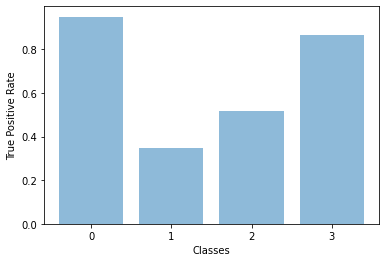

In [23]:
class_acc = calculate_class_acc_for_test_set(model_simple)
plot_class_acc(class_acc)

Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master


Confusion matrix:
 [[58.  2.  0.  0.]
 [18. 30. 12.  0.]
 [22.  8. 30.  0.]
 [ 3.  2. 17. 38.]]
Class acc:
 [0.9666666666666667, 0.5, 0.5, 0.6333333333333333]


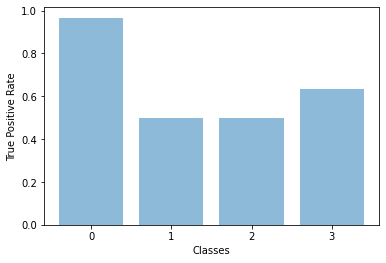

In [24]:
model_without_wl = t.nn.DataParallel(get_res_next_101().cuda())
checkpoint_without_wl = t.load(CHACKPOINT_CROSS_ENTROPY_MODEL)
model_without_wl.load_state_dict(checkpoint_without_wl['model'])
class_acc_no_wl = calculate_class_acc_for_test_set(model_without_wl)
plot_class_acc(class_acc_no_wl)

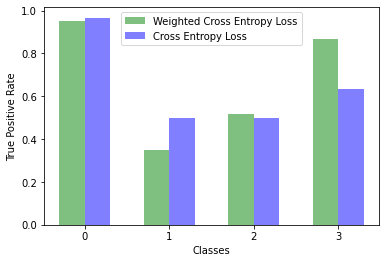

In [25]:
plot_class_acc_comparison(class_acc, class_acc_no_wl, 'Weighted Cross Entropy Loss', 'Cross Entropy Loss')